In [4]:
# Basics
import numpy as np
import yfinance as yf
import pandas as pd

# Models
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression

# Metrics
from ta import add_all_ta_features
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from  sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# data
df = yf.download('^RUA',start = '2018-01-01',end = '2022-01-01')
df.reset_index(inplace = True) #resetting index

df['pct_ret'] = df['Adj Close'].pct_change()
df['state'] = df['pct_ret'].apply(lambda x: 2 if (x > 0.001) else (0 if (x < -0.001)else 1))
df.dropna(inplace = True)

# Add ta features filling NaN values
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

df = df.dropna()
df1 = df
df.tail()

[*********************100%***********************]  1 of 1 completed


C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Date,Open,High,Low,Close,Adj Close,Volume,pct_ret,state,volume_adi,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
974,2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,2,1.083229e+07,...,-0.089888,-10.780630,1.507913,-100.0,-100.0,-2.038367e-08,2725.955470,1.278009,1.269911,74.667179
975,2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,0,1.083229e+07,...,-9.217359,14.832777,2.291593,-100.0,-100.0,-1.862753e-08,2729.177026,-0.192239,-0.192424,74.331400
976,2021-12-29,2798.379883,2807.370117,2791.860107,2801.870117,2801.870117,0,0.001258,2,1.083229e+07,...,-7.088402,34.775790,1.686884,-100.0,-100.0,-1.702269e-08,2734.793633,0.125789,0.125710,74.550690
977,2021-12-30,2802.909912,2813.250000,2794.189941,2795.909912,2795.909912,0,-0.002127,0,1.083229e+07,...,-10.693218,47.147694,2.443553,-100.0,-100.0,-1.555611e-08,2736.827065,-0.212722,-0.212949,74.179382
978,2021-12-31,2793.810059,2800.500000,2788.129883,2788.139893,2788.139893,0,-0.002779,0,1.083229e+07,...,-15.392634,52.381720,2.976867,-100.0,-100.0,-1.421590e-08,2740.134746,-0.277907,-0.278294,73.695325


In [6]:
# Columns for X, y, and date
columns = ['Adj Close','pct_ret','momentum_wr','momentum_ao','momentum_roc']
target = 'state'
date_column = 'Date'

In [7]:
def datetime_index(df, date_column):
    if (date_column in df.columns):
        df[date_column]= pd.to_datetime(df[date_column])
        df = df.set_index(date_column, drop = True).asfreq('D')
        df = df.sort_index(ascending = True)
    else:
        print("datetime_index Already done")
        print(df.index)
datetime_index(df, date_column)


In [8]:
def adf_test(data):
    if adfuller(data)[1]>0.05:
        is_stationary = False
        # print('Because p-value>0.05, the null hypothesis cannot be rejected, the data is not stationary')
    else:
        is_stationary = True
        # print('Because p-value<0.05, the null hypothesis can be rejected, the data is stationary')
    return adfuller(data), is_stationary
adf_test(df['Close'])

((0.15767246173298155,
  0.9697851110807065,
  9,
  968,
  {'1%': -3.437123476942836,
   '5%': -2.8645304098119544,
   '10%': -2.568362253987091},
  8688.867111328309),
 False)

In [9]:
def stationary_time_series(data):
    return seasonal_decompose(data, model='additive',period = 30).resid
close_stationary = stationary_time_series(df['Close'])
adf_test(close_stationary.dropna())

((-10.347320559107901,
  2.590593168618638e-18,
  10,
  937,
  {'1%': -3.4373481911362997,
   '5%': -2.864629502968925,
   '10%': -2.56841503507527},
  8216.177035424716),
 True)

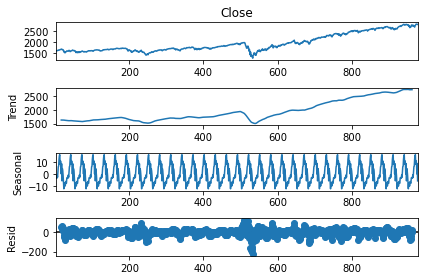

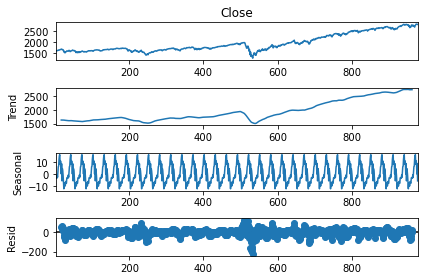

In [10]:
seasonal_decompose(df['Close'], model='additive',period = 30).plot()

In [11]:
X = df[columns].to_numpy()
y = df['state']

In [262]:
# Using PCA to get feature importance
# Compared
pca = PCA(n_components=0.95)
pca.fit(X)
pca.explained_variance_ratio_

array([0.97195579])

In [244]:
# Using Linear Regression to get feature importance
def linear_regression_test(X,y):
    model_0 = LinearRegression()
    model_0.fit(X, y)
    importance = model_0.coef_
    r2 = r2_score(y, model_0.predict(X))

    return importance, r2
linear_regression_test(X,y)

(array([-7.09948930e-06,  4.07632159e+01,  9.99563450e-03,  4.83762390e-04,
        -5.09452876e-02]),
 0.4766999287985848)

[0.00715351 1.         0.34446517 0.01104946 0.08352238]


<BarContainer object of 5 artists>

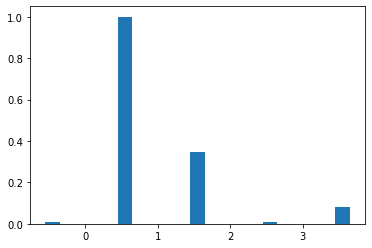

In [247]:
# Feature selection
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
X_indices = np.arange(X.shape[-1])
selector = SelectKBest(f_classif, k=1)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print(scores)
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

<AxesSubplot:>

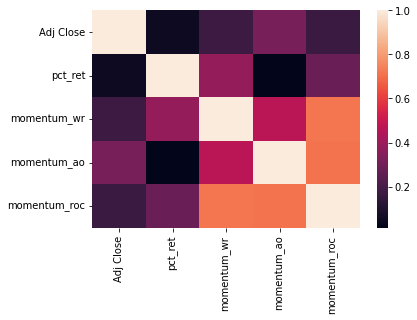

In [248]:
corr_matrix = df[columns].corr()
sns.heatmap(corr_matrix)

In [249]:
def feature_selection_corr (df, columns):
    corr_matrix = df[columns].corr()
    selected_columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            # threshold here is 0.9
            if corr_matrix.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False
    selected_columns = corr_matrix.columns[selected_columns]
    return selected_columns
feature_selection_corr(df, columns)

Index(['Adj Close', 'pct_ret', 'momentum_wr', 'momentum_ao', 'momentum_roc'], dtype='object')

In [251]:
df

,Open,High,Low,Close,Adj Close,Volume,pct_ret,state,volume_adi,volume_obv,...,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,1595.839966,1605.890015,1595.839966,1605.189941,1605.189941,0,0.005840,2,0.000000e+00,0,...,-6.965869,0.000000,0.000000,0.0,0.0,0.000000e+00,1605.189941,-17.651403,0.000000,0.000000
2018-01-04,1605.699951,1613.839966,1605.699951,1611.020020,1611.020020,0,0.003632,2,0.000000e+00,0,...,-15.666368,0.000000,0.000000,0.0,0.0,0.000000e+00,1607.297655,0.363202,0.362544,0.363202
2018-01-05,1612.140015,1621.479980,1612.140015,1621.369995,1621.369995,0,0.006424,2,0.000000e+00,0,...,-0.428960,0.000000,0.000000,0.0,0.0,0.000000e+00,1612.676286,0.642449,0.640394,1.007984
2018-01-08,1621.280029,1624.780029,1617.640015,1624.349976,1624.349976,0,0.001838,2,0.000000e+00,0,...,-1.486015,0.000000,0.000000,0.0,0.0,0.000000e+00,1617.289334,0.183794,0.183625,1.193630
2018-01-09,1624.349976,1630.630005,1624.349976,1625.920044,1625.920044,0,0.000967,1,0.000000e+00,0,...,-13.538246,0.000000,0.000000,0.0,0.0,0.000000e+00,1620.780760,0.096658,0.096612,1.291442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,0.012780,2,1.083229e+07,-161500,...,-0.089888,-10.780630,1.507913,-100.0,-100.0,-2.038367e-08,2725.955470,1.278009,1.269911,74.667179
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,-0.001922,0,1.083229e+07,-161500,...,-9.217359,14.832777,2.291593,-100.0,-100.0,-1.862753e-08,2729.177026,-0.192239,-0.192424,74.331400
2021-12-29,2798.379883,2807.370117,2791.860107,2801.870117,2801.870117,0,0.001258,2,1.083229e+07,-161500,...,-7.088402,34.775790,1.686884,-100.0,-100.0,-1.702269e-08,2734.793633,0.125789,0.125710,74.550690


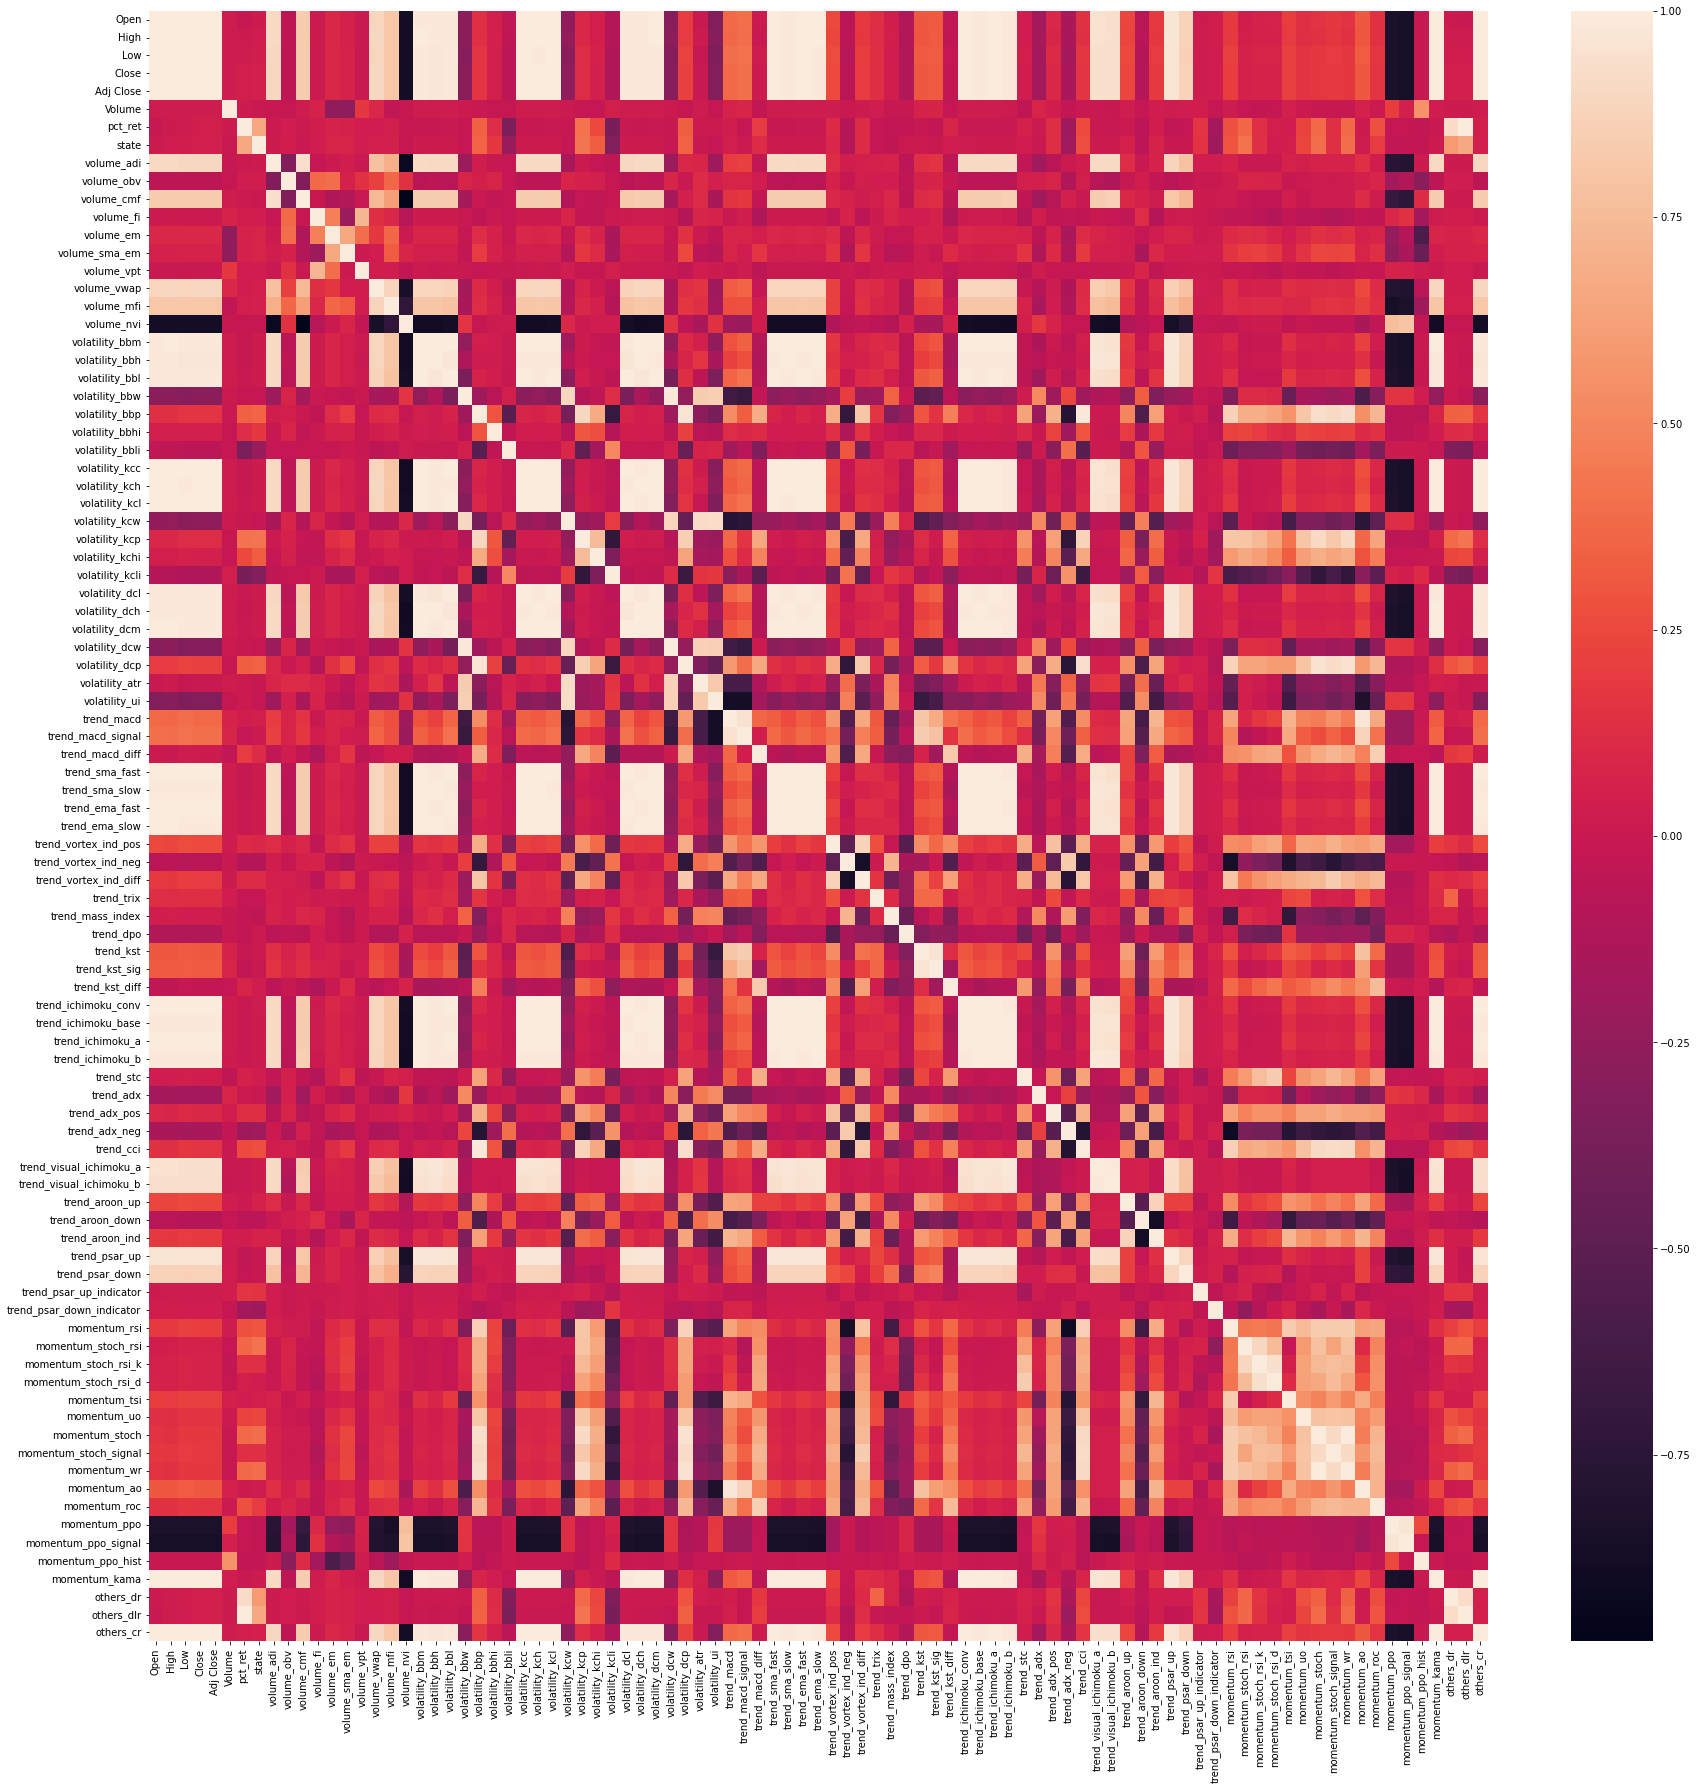

In [258]:
fig, ax = plt.subplots(figsize=(30,30))
ax = sns.heatmap(df.corr())

In [ ]:
# params = {}

# def training_model(X,y,params):
#     for param in params:
#         model = initiation(params)
#         model.fit(X,y)
#         compare model using cross validation
#     return model

# def test_data(X,y,model):
#     make a df with
#         - date index
#         - X
#         - y_pred 
#     no comparason, only data thats used for trading
#     return test_df


In [21]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
# pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
# pyplot.show()

[10:07:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0. 1. 0. 0. 0.]


C:\Users\lemon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X, y)
sel.get_support()

array([False,  True, False, False, False])

In [53]:
df = pd.read_csv('data11.csv')
datetime_index(df, date_column)
# df.columns.drop('state')
# Columns for X, y, and date
columns = df.drop(columns = ['state.1','Date','state']).columns
target = 'state'
date_column = 'Date'

X = df[columns].to_numpy()
y = df['state']

In [62]:
model = SelectFromModel(XGBClassifier())
model.fit(X, y)
xgb_result = model.get_support()
model.get_support()

C:\Users\lemon\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False, False, False, False,  True, False, False,  True,
        True, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True, False,  True, False,
        True, False,  True,  True, False, False, False, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False])

In [63]:
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X, y)
RandomForest = sel.get_support()
sel.get_support()

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
        True, False, False, False, False,  True,  True, False, False,
       False, False, False])

In [ ]:
import pomegranate as pg
X = X_train
y = y_train
distribution = pg.MultivariateG
distribution

In [57]:
pip install pomegranate

Note: you may need to restart the kernel to use updated packages.
